# Danny's Data Bank Project

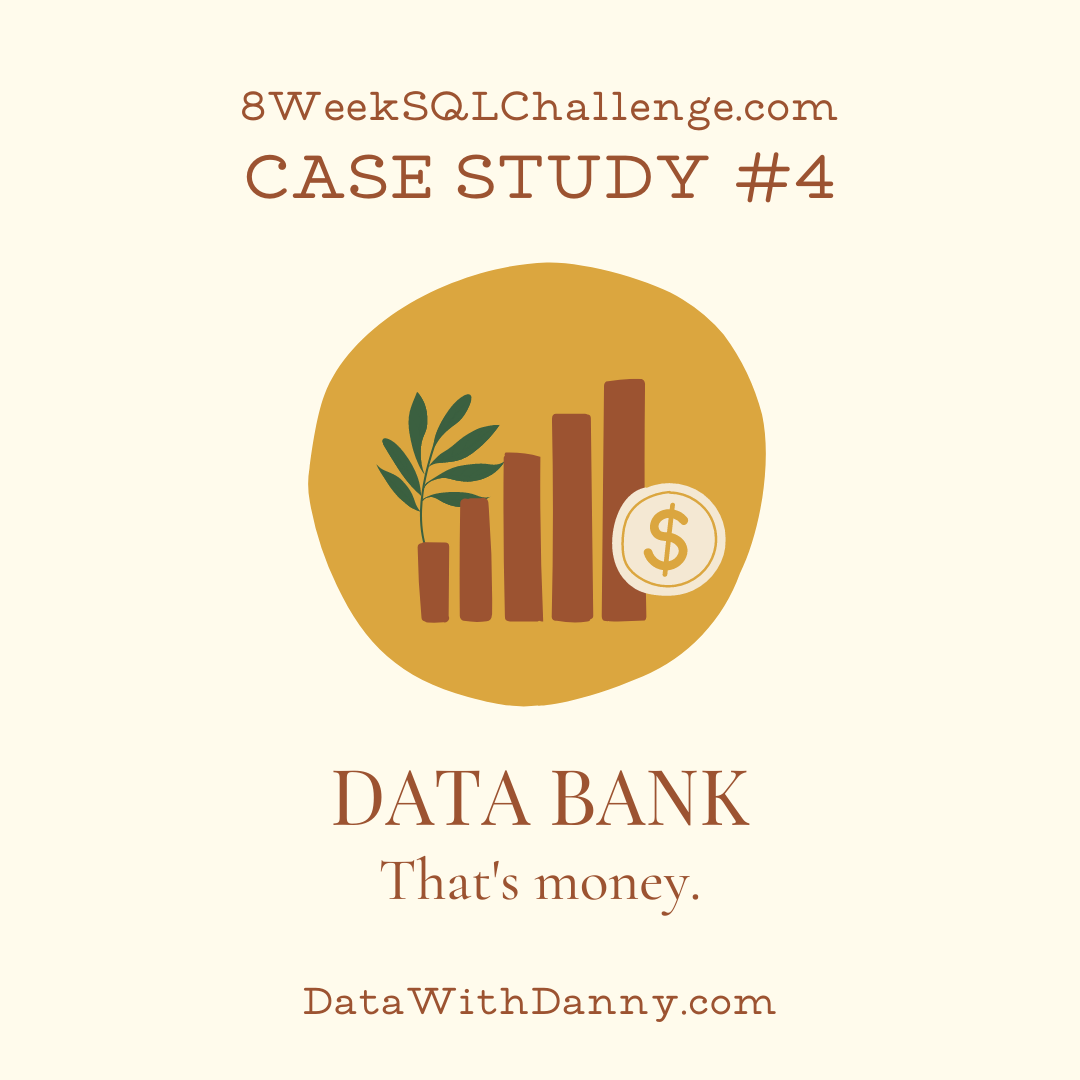

## Introduction

There is a new innovation in the financial industry called Neo-Banks: new aged digital only banks without physical branches.

Danny thought that there should be some sort of intersection between these new age banks, cryptocurrency and the data world…so he decides to launch a new initiative - Data Bank!

Data Bank runs just like any other digital bank - but it isn’t only for banking activities, they also have the world’s most secure distributed data storage platform!

Customers are allocated cloud data storage limits which are directly linked to how much money they have in their accounts. There are a few interesting caveats that go with this business model, and this is where the Data Bank team need your help!

The management team at Data Bank want to increase their total customer base - but also need some help tracking just how much data storage their customers will need.

This case study is all about calculating metrics, growth and helping the business analyse their data in a smart way to better forecast and plan for their future developments!

## Available Data

The Data Bank team have prepared a data model for this case study as well as a few example rows from the complete dataset below to get you familiar with their tables.

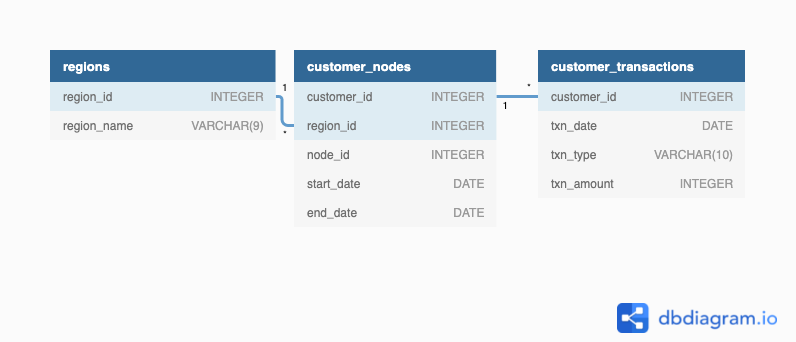

### Table 1: Regions

Just like popular cryptocurrency platforms - Data Bank is also run off a network of nodes where both money and data is stored across the globe. In a traditional banking sense - you can think of these nodes as bank branches or stores that exist around the world.

This regions table contains the region_id and their respective region_name values

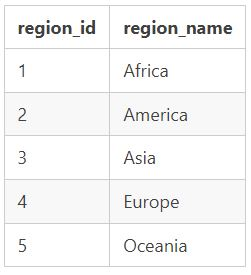

### Table 2: Customer Nodes

Customers are randomly distributed across the nodes according to their region - this also specifies exactly which node contains both their cash and data.

This random distribution changes frequently to reduce the risk of hackers getting into Data Bank’s system and stealing customer’s money and data!

Below is a sample of the top 10 rows of the data_bank.customer_nodes

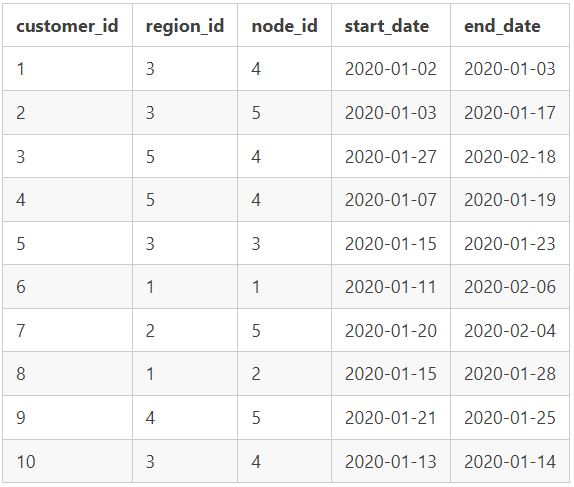

### Table 3: Customer Transactions

This table stores all customer deposits, withdrawals and purchases made using their Data Bank debit card.

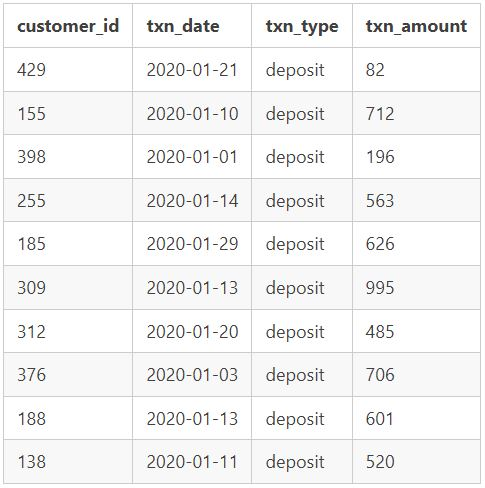

## Case Study Questions

### A. Customer Nodes Exploration

> <h4>How many unique nodes are there on the Data Bank system?</h4>

- To get the unique nodes in the system, i simply used distinct function to filter out the different node numbers then used the count function to get their number

``` mysql
SELECT COUNT( DISTINCT node_id)
FROM customer_nodes;
```

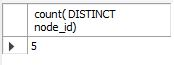

> <h4>What is the number of nodes per region?</h4>

- The relationship between the regions to customer_nodes table is a one to many, which means that each customer has one region but since the customer nodes tables record customer data reallocation customer information are recorded multiple times
- to retrieve this data, i joined the regions table to the customer_nodes using the region id using an inner join
- then I got the regions name from the regions table and used a combination of count and distinct to get the data

``` mysql
SELECT r.region_name,
       COUNT( DISTINCT cn.node_id) AS nodes_per_region
FROM customer_nodes cn
JOIN regions r
ON cn.region_id = r.region_id
GROUP BY cn.region_id
ORDER BY cn.region_id;
```

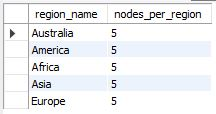

> <h4>How many customers are allocated to each region?</h4>

- Applying thesame logic from question number 2, then applied the count distinct function on customer id

``` mysql
SELECT r.region_name,
       COUNT( DISTINCT cn.customer_id) AS customer_per_person
FROM customer_nodes cn
JOIN regions r
ON cn.region_id = r.region_id
GROUP BY cn.region_id
ORDER BY cn.region_id;
``` 

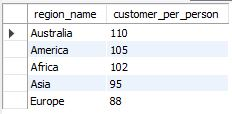

> <h4>How many days on average are customers reallocated to a different node?</h4>

- The customer nodes table records customer information and the node they are allocated to within a particular period of time
- To get this data, I simply subtract the end date from the start date using DATEDIFF, which is used in getting the difference between two dates in days
- I then apply the Average function (AVG) on DATEDIFF to get the average for all periods of reallocation
- However, I noticed the answer i got was a bit larger than expected, upon ivestigation, there were some end date with the year 9999. Since most of the recorded event took place within the first four months of 2020, we can simply correct this data with UPDATE statement, however, the number of incorrect end date were not much and can be simply be removed using a WHERE clause

FIRST METHOD

``` MYSQL
SELECT AVG(DATEDIFF(end_date, start_date)) AS Average_days
FROM customer_nodes
WHERE end_date <> '9999-12-31';
``` 

SECOND METHOD

``` MYSQL
SELECT
SUM(DATEDIFF(end_date, start_date))/ COUNT(*) AS Average_days
FROM customer_nodes
WHERE end_date <> '9999-12-31';
```

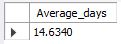

> <h4>What is the median, 80th and 95th percentile for this same reallocation days metric for each region?</h4>

- Getting the data for this question was a little bit tricky, due to MYSQL not having functions like "PERCENTILE", "WITHIN GROUP" and the likes
- to get the median, 80th and 95th percentile, I needed to arrange each reallocation period from minimum to the maximum number of days 
- hence, i had to use two Common Table Expressions (CTEs), the first to get the number of days before reallocation (diff_date) and to order this reallocation days from minimum to maximum for each region (partition_region)
- The first CTE, part_by_region, gets the regiond_id, the number of days before reallocation (diff_date), then using the ROW_NUMBER window function, I numbered each allocation for each region using PARTITION BY in the windows function and ordered each number of days before reallocation from minimu to maximum using ORDER BY within the window function
- The second CTE, percentile, MYSQL has the PERCENT_RANK window function that computes the relative relative rank of a row within a group of rows, rangong from 0 to 1
- The final query uses multiple subqueries to calculate the columns to get the median, 80th and 95th percentile, by filtering out data where the PERCENT_RANK window function has 0.5, 0.8 and 0.95 for the median, 80th and 95th percentile respectively. then taking the average to get each percentiles value

``` MYSQL
WITH part_by_region AS (
    SELECT cn.region_id,
           DATEDIFF(end_date, start_date) AS diff_date,
           ROW_NUMBER() OVER(PARTITION BY cn.region_id ORDER BY DATEDIFF(end_date, start_date)) AS partition_region
    FROM customer_nodes cn
    JOIN regions r
    ON cn.region_id = r.region_id
    WHERE end_date <> '9999-12-31'),

percentile AS (
    SELECT *,
           ROUND(PERCENT_RANK() OVER(PARTITION BY region_id ORDER BY partition_region),2) AS percentile_r
    FROM part_by_region)

SELECT r.region_name,
       (SELECT
               ROUND(SUM(diff_date)/COUNT(*))
        FROM percentile
        WHERE percentile_r = 0.5) AS median,
       (SELECT
               ROUND(SUM(diff_date)/COUNT(*))
        FROM percentile
        WHERE percentile_r = 0.8) AS eighty_percentile,
        (SELECT
               ROUND(SUM(diff_date)/COUNT(*))
        FROM percentile
        WHERE percentile_r  = 0.95) AS ninety_five_percentile
FROM percentile p
JOIN regions r
ON p.region_id = r.region_id
GROUP BY p.region_id;
``` 

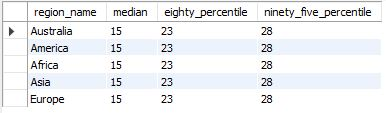

### B. Customer Transactions

> <h4>What is the unique count and total amount for each transaction type?</h4>

- The customer transacions table records all transactions and each transaction type (Deposit, Purchase, Withdrawal)
- using the GROUP BY function on the txn type column, I aggreagte each record of transaction using the COUNT function and using the SUM function I got the total amount for each transaction type

``` MYSQL
SELECT txn_type,
       COUNT(*) as unique_count,
       SUM(txn_amount) AS total_amount
FROM customer_transactions
GROUP BY txn_type;
```

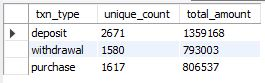

> <h4>What is the average total historical deposit counts and amounts for all customers?</h4>

- First I would need to get the total number of transaction for each type made by each cutomer and the amounts total amount for each type of transaction per customer, then take the average of the count and sum
- To do this, I used a subquery to prepare a table that grouped the transaction record by the transaction type column using GROUP BY then used the COUNT  and SUM functions to get the number of transactions and total amount for each customer
- In the main query, I took the average for the count and total amount from the table in the subquery and rounded them to 1 decimal place using the ROUND function

``` MYSQL
SELECT
      ROUND(AVG(unique_count),1) AS avg_unique_count,
      ROUND(AVG(total_amount),1) AS avg_total_amount
FROM(
      SELECT customer_id, txn_type,
             COUNT(*) AS unique_count,
             SUM(txn_amount) AS total_amount
      FROM customer_transactions
      WHERE txn_type = 'deposit'
      GROUP BY customer_id) as customer_deposits;
```

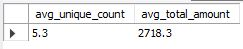

> <h4>For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?</h4>

- First I prepared a table to group each transaction by the customer id and the month, which i got the month number by using the EXTRACT statement. I then seprated each transaction type into different columns using the CASE statement, finally summing them up to get the number of deposit, purchase and withdrawal in each column
- using the prepared table in a subquery I then filter to only customer that are within our segment(> 1 deposit, >= 1 purchase/withdrawal) using the WHERE function then use the COUNT function to get their total number

``` MYSQL
SELECT month_num,
       COUNT(customer_id) AS customer_count
FROM(
       SELECT customer_id,
            EXTRACT(MONTH FROM txn_date) AS month_num,
            SUM(CASE WHEN txn_type = 'deposit' THEN 1 ELSE 0 END) AS deposit,
            SUM(CASE WHEN txn_type = 'purchase' THEN 1 ELSE 0 END) AS purchase,
            SUM(CASE WHEN txn_type = 'withdrawal' THEN 1 ELSE 0 END) AS withdrawal
       FROM customer_transactions
       GROUP BY customer_id, EXTRACT(MONTH FROM txn_date)) AS count_type
WHERE deposit > 1 AND (purchase > 0 OR withdrawal > 0)
GROUP BY month_num
ORDER BY month_num;
```

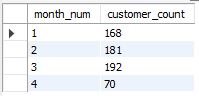

> <h4>What is the closing balance for each customer at the end of the month?</h4>

- the closing balance for each customer is the amount that is in a customers account at the end of a period of time after the customer made different types od transactions. here we require the closing balance at the last day of the month
- First, I calculate the amount in a customers account after each transaction by using the CASE statement to classify deposit as positive transaction and our withdrawals and purcahse as negative transactions. I then put this query in a CTE (transactions)
- Then write a query referencing data from the CTE transactions and SUM the classified transaction column using a window function to partition by each customer in the order of each month. The wincow function sums all the transactions, both negative and positive, in a month inclusing the balance from last month

``` MYSQL
WITH transactions AS (
          SELECT customer_id,
                 EXTRACT(MONTH FROM txn_date) AS month_num,
                 MAX(txn_date) AS last_date,
                 SUM(CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END) AS closing_balance
          FROM customer_transactions
          GROUP BY EXTRACT(MONTH FROM txn_date), customer_id)

SELECT customer_id,
       month_num, last_date,
       SUM(closing_balance) OVER (PARTITION BY customer_id ORDER BY month_num) AS closing_balance
FROM transactions;
```

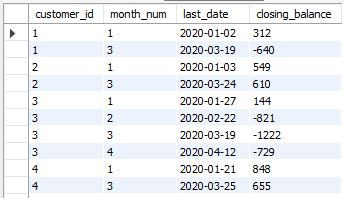

Results were too long to show fully, the above is just a sample of the query result

> <h4>What is the percentage of customers who increase their closing balance by more than 5%?</h4>

- First get closing balance and put it in a CTE cb, then create a new column than bring the former closing balance to the same row as the present balance to calaculate the difference and get the percentage
- then in the final query get the percentage of the distinct customers who had a percentage increase on their closing balance to the entire number of customers

``` MYSQL
WITH cb AS (
       SELECT customer_id,
              month_num, last_date,
              SUM(closing_balance) OVER (partition by customer_id order by month_num) AS closing_balance
       FROM(
              SELECT customer_id,
                     EXTRACT(MONTH FROM txn_date) AS month_num,
                     MAX(txn_date) AS last_date,
                     SUM(CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END) AS closing_balance
              FROM customer_transactions
              GROUP BY EXTRACT(MONTH FROM txn_date), customer_id) AS transactions),

     get_prev_month AS (
       SELECT *,
              LAG(closing_balance) OVER (PARTITION BY customer_id ORDER BY month_num) AS prev_closing_balance
       FROM cb),

     new_tab AS (
       SELECT *,
              (closing_balance-prev_closing_balance)/prev_closing_balance AS percentage
       FROM get_prev_month
       WHERE prev_closing_balance)

SELECT COUNT( DISTINCT customer_id)/(SELECT COUNT(DISTINCT customer_id) FROM customer_transactions)*100 AS percent_customers
FROM new_tab
WHERE percentage > 0.05;
```

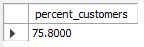

### C. Data Allocation Challenge

To test out a few different hypotheses - the Data Bank team wants to run an experiment where different groups of customers would be allocated data using 3 different options:

- Option 1: data is allocated based off the amount of money at the end of the previous month
- Option 2: data is allocated on the average amount of money kept in the account in the previous 30 days
- Option 3: data is updated real-time

For this multi-part challenge question - you have been requested to generate the following data elements to help the Data Bank team estimate how much data will need to be provisioned for each option:

- running customer balance column that includes the impact each transaction
- customer balance at the end of each month
- minimum, average and maximum values of the running balance for each customer

> <H4>running customer balance column that includes the impact each transaction</H4>

- The ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW in the window function shows the running balance after each transaction was made for each customer

``` MYSQL
WITH spend AS (
        SELECT customer_id,
               txn_date,
               txn_type,
               txn_amount,
               CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END AS transactions
        FROM customer_transactions)

SELECT customer_id,
       txn_date,
       transactions,
       SUM(transactions) OVER(PARTITION BY customer_id ORDER BY txn_date
       ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS running_balance
FROM spend;
```

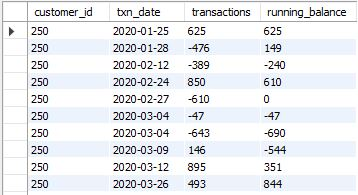

Results were too long to show fully, the above is just a sample showing the running balance of a customer with ID 250

> <H4>customer balance at the end of each month</H4>

``` MYSQL
WITH transactions AS (
       SELECT customer_id,
              EXTRACT(month FROM txn_date) AS month_num,
              MAX(txn_date) AS last_date,
              SUM(CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END) AS closing_balance
       FROM customer_transactions
       GROUP BY EXTRACT(month FROM txn_date), customer_id)

SELECT customer_id,
       month_num, last_date,
       SUM(closing_balance) OVER (partition by customer_id order by month_num) AS closing_balance
FROM transactions;
```

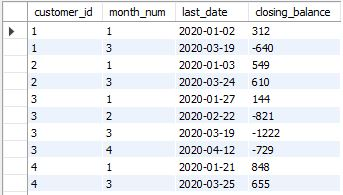

Results were too long to show fully, the above is just a sample of the results

> <H4>minimum, average and maximum values of the running balance for each customer</H4>

- Take the average, minimum and maximum of the running balance

``` MYSQL
WITH spend AS (
        SELECT customer_id,
               txn_date,
               txn_type,
               txn_amount,
               CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END AS transactions
        FROM customer_transactions),

     run_bal AS (
        SELECT customer_id,
               txn_date,
               transactions,
               SUM(transactions) OVER(PARTITION BY customer_id ORDER BY txn_date
               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS running_balance
        FROM spend)

SELECT customer_id,
       MIN(running_balance) AS minimum_balance,
       MAX(running_balance) AS maximum_balance,
       AVG(running_balance) AS average_balance
FROM run_bal
GROUP BY customer_id;
```

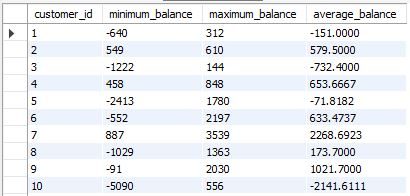

Results were too long to show fully, the above is just a sample of the result

### Data Allocation Options per Month

> <h4>Option 1: data is allocated based off the amount of money at the end of the previous month</h4>

- Get the running balance in the first CTE spend
- Then in the second CTE get the last date of transaction using MAX on txn_date and partition using window function
- Finally sum the balance for each month

``` MYSQL
WITH spend AS (
        SELECT customer_id,
               txn_date,
               txn_type,
               txn_amount,
               CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END AS transactions
        FROM customer_transactions),

     cte1 AS (
        SELECT customer_id,
               txn_date,
               transactions,
               MAX(txn_date) OVER(PARTITION BY customer_id, EXTRACT(MONTH FROM txn_date)) AS last_date,
               SUM(transactions) OVER(PARTITION BY customer_id ORDER BY txn_date) AS running_balance
        FROM spend)

SELECT EXTRACT(MONTH FROM txn_date) AS month,
       SUM(running_balance) AS amount_at_end_of_month
FROM cte1
WHERE running_balance > 0 AND
      txn_date = last_date
GROUP BY EXTRACT(MONTH FROM txn_date)
ORDER BY EXTRACT(MONTH FROM txn_date);
```

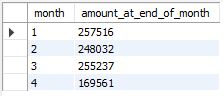

> <h4>Option 2: data is allocated on the average amount of money kept in the account in the previous 30 days</h4>

``` MYSQL
-- Generate a list of dates for each day in the specified period
WITH RECURSIVE DateRange AS (
    SELECT DATE('2020-01-01') AS Date
    UNION ALL
    SELECT Date + INTERVAL 1 DAY
    FROM DateRange
    WHERE Date < '2020-04-30'
),

-- Cross join the list of dates with the distinct list of customers to get all combinations
-- This will generate a day for each month for each customer from the 1st of January to 30th of April, 2020
date_for_cust AS (
    SELECT d.Date,
           c.customer_id
    FROM DateRange d
    CROSS JOIN 
           (SELECT DISTINCT customer_id FROM customer_transactions) c
    LEFT JOIN 
           customer_transactions ct ON ct.txn_date = d.Date AND ct.customer_id = c.customer_id
    ORDER BY 
           c.customer_id, d.Date),
    
-- Group the amount of purchase into negative values for withdrawals and purchase, positive for deposits
txn_group AS (
    SELECT customer_id,
           txn_date,
           txn_type,
           txn_amount,
           CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END AS transactions
    FROM customer_transactions),
    
-- Add the transaction amount for each customer for each day of the month
/* (this will also input the transaction amount balance from the last transaction for the days the customer did not make any transactions)*/
add_txn AS (
    SELECT dfc.date AS gen_date,
           dfc.customer_id AS gen_cust, transactions
    FROM date_for_cust dfc
    LEFT JOIN txn_group tg
    ON dfc.date = tg.txn_date and dfc.customer_id = tg.customer_id),

-- Calculate the running balance for each customer for each day of the month using the generated days of the month column
cal_run_bal AS (
    SELECT gen_date,
           gen_cust,
           transactions,
           SUM(transactions) OVER(PARTITION BY gen_cust ORDER BY gen_date
               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS running_balance
    FROM add_txn),

-- Calculate the average for each customer for each month
cal_avg_run AS (
    SELECT *,
           AVG(running_balance) OVER(PARTITION BY gen_cust ORDER BY gen_date) AS avg_30_balance
    FROM cal_run_bal
    WHERE running_balance IS NOT NULL
    GROUP BY gen_cust, EXTRACT(MONTH FROM gen_date))

-- Sum the average of each customer to get total for each value
SELECT EXTRACT(MONTH FROM gen_date) AS months,
       ROUND(SUM(avg_30_balance),1) AS total
FROM cal_avg_run
WHERE avg_30_balance > 0
GROUP BY months
ORDER BY months;
```

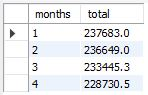

> <h4>Option 3: data is updated real-time</h4>

``` MYSQL
WITH spend AS (
        SELECT customer_id,
               txn_date,
               txn_type,
               txn_amount,
               CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END AS transactions
        FROM customer_transactions),

     run_bal AS (
        SELECT customer_id,
               txn_date,
               transactions,
               EXTRACT(MONTH FROM txn_date) AS month_num,
               SUM(transactions) OVER(PARTITION BY customer_id ORDER BY txn_date
               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS running_balance
        FROM spend)

SELECT month_num,
       SUM(running_balance) AS total
FROM run_bal
WHERE running_balance > 0
GROUP BY month_num
ORDER BY month_num;
```

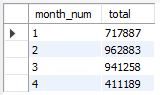

## D. Extra Challenge

Data Bank wants to try another option which is a bit more difficult to implement - they want to calculate data growth using an interest calculation, just like in a traditional savings account you might have with a bank.

If the annual interest rate is set at 6% and the Data Bank team wants to reward its customers by increasing their data allocation based off the interest calculated on a daily basis at the end of each day, how much data would be required for this option on a monthly basis?

Special notes:

- Data Bank wants an initial calculation which does not allow for compounding interest, however they may also be interested in a daily compounding interest calculation so you can try to perform this calculation if you have the stamina!

- In traditional Banks, Interest is given to customers over as period of time at a certain rate.
- the interest is calculated on the customer balance at the end of each day with the formula: (principal * Time * (Rate/365))
- Then sum the interest on each closing balance each day get the total for eac month
- Get the running balance, use LEAD window function to get the next date a transaction was made by the customer within that month, if the transaction was the last made in a month use CASE statement to replace NULL with the Last date in the month using LAST_DAY
- The time in the interest formula is 1 day, therefore for each day the customer does not make a transaction they recieve thesame daily interest until they make a transaction then their daily interest changes
- therefore the period is the number of days within wich a customer balance remains thesame, if it is the last transaction a customer made the period is the number of days between their last transaction and the end of the month 
- Get the period in a subquery then calculate the interest after each transaction
- Finally sum the interest and group by the month

``` MYSQL
-- Group the amount of purchase into negative values for withdrawals and purchase, positive for deposits
-- Get the next transaction date, so as to know the number of days a customer held a certain amount of balance
WITH cte1 AS (
         SELECT customer_id,
                txn_date, transactions,
                SUM(transactions) OVER(PARTITION BY customer_id ORDER BY txn_date) AS running_balance,
                LEAD(txn_date) OVER(PARTITION BY customer_id ORDER BY txn_date) AS next_txn_date1
         FROM (
                SELECT customer_id,
                       txn_date,
                       txn_type,
                       txn_amount,
                       CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE -txn_amount END AS transactions
                FROM customer_transactions) AS spend),

-- For the last transaction a customer made, we calculate the interest till the end of that last month
     cte2 AS (
         SELECT customer_id,
                txn_date,
                running_balance,
                CASE WHEN next_txn_date1 IS NULL
                THEN LAST_DAY(txn_date) ELSE next_txn_date1 END AS next_txn_date,
                CASE WHEN running_balance < 0
                THEN 0 ELSE running_balance END AS balance
         FROM cte1),

/* Calculate the Interest using the formula: Principal*(interest/365)*period
With the principal being the balance after a transaction
The annual interest is divided by 365 to get the interest for each day of a year
Then multiply by the number of days the customer held thesame balance
(this gives us the sum of interest for the days the balance was thesame for each customer until they made a transaction)*/
     cte3 AS (
         SELECT *,
                balance*(0.06/365)*period AS interest
         FROM(
                SELECT *,
                       DATEDIFF(next_txn_date, txn_date) AS period
                FROM cte2) AS final)

-- Sum the interest of all customers for each month
SELECT
EXTRACT(MONTH FROM txn_date) AS month_num,
SUM(interest) AS total_interest
FROM cte3
GROUP BY EXTRACT(MONTH FROM txn_date)
ORDER BY EXTRACT(MONTH FROM txn_date);
```

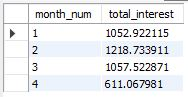

## Extension Request

The Data Bank team wants you to use the outputs generated from the above sections to create a quick Powerpoint presentation which will be used as marketing materials for both external investors who might want to buy Data Bank shares and new prospective customers who might want to bank with Data Bank.

- Using the outputs generated from the customer node questions, generate a few headline insights which Data Bank might use to market it’s world-leading security features to potential investors and customers.

- With the transaction analysis - prepare a 1 page presentation slide which contains all the relevant information about the various options for the data provisioning so the Data Bank management team can make an informed decision.

The Power Point file for this requet can be found <a href="https://github.com/OkikiAde100/Danny-s-Data-Bank/blob/main/Danny's%20Data%20Bank%20Marketing.pptx" >here</a>